In [9]:
%pip install tqdm


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Предсказание погоды на следующий день: 
Будет дождь, если rainfall >=1

In [11]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Удалим столбцы

In [12]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

Удаление строк с пропущенными значениями

In [13]:
df = df.dropna()
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No


Преобразование данных стобца

In [14]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

C:\Users\usicc\AppData\Local\Temp\ipykernel_15340\3734455367.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
C:\Users\usicc\AppData\Local\Temp\ipykernel_15340\3734455367.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday

Классы несбалансированы

In [15]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Преобразуем в тензор

In [16]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


#NN

In [17]:

class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 8)
    self.fc2 = nn.Linear(8, 4)
    self.fc3 = nn.Linear(4, 1)
    
    # torch.nn.init.xavier_uniform_(self.fc1.weight) 

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [18]:
criterion = nn.BCELoss()

In [19]:
device = torch.device( "cpu")

In [20]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [21]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [ ]:
net = Net(4)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
net = net.to(device)                            

criterion = criterion.to(device)

for epoch in range(2000):

    train_loss = 0
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
        
    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    if epoch % 100 == 0:

          y_test_pred = net(X_test)
          y_test_pred = torch.squeeze(y_test_pred)

          test_loss = criterion(y_test_pred, y_test)

          test_acc = calculate_accuracy(y_test, y_test_pred)
          print(
    f'''epoch {epoch}
    Test  set - loss: {test_loss}, accuracy: {test_acc}
    ''')

epoch 0
    Test  set - loss: 7.164628505706787, accuracy: 0.2216697335243225
    
epoch 100
    Test  set - loss: 0.5720796585083008, accuracy: 0.796014130115509
    
epoch 200
    Test  set - loss: 0.5436038970947266, accuracy: 0.7788916230201721
    
epoch 300
    Test  set - loss: 0.5333546996116638, accuracy: 0.7793327569961548
    
epoch 400
    Test  set - loss: 0.5154785513877869, accuracy: 0.7796936631202698
    
epoch 500
    Test  set - loss: 0.480743408203125, accuracy: 0.7794530391693115
    
epoch 600
    Test  set - loss: 0.4678124487400055, accuracy: 0.7808966040611267
    
epoch 700
    Test  set - loss: 0.4557696580886841, accuracy: 0.784866452217102
    
epoch 800
    Test  set - loss: 0.44445258378982544, accuracy: 0.7911219596862793
    
epoch 900
    Test  set - loss: 0.4336603879928589, accuracy: 0.7984601855278015
    
epoch 1000
    Test  set - loss: 0.424217164516449, accuracy: 0.8103296160697937
    
epoch 1100
    Test  set - loss: 0.41721048951148987, accur

In [23]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

In [24]:
net = torch.load(MODEL_PATH)

C:\Users\usicc\AppData\Local\Temp\ipykernel_15340\804352145.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(MODEL_PATH)


In [25]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.79      0.68      0.71     24938
weighted avg       0.82      0.84      0.82     24938



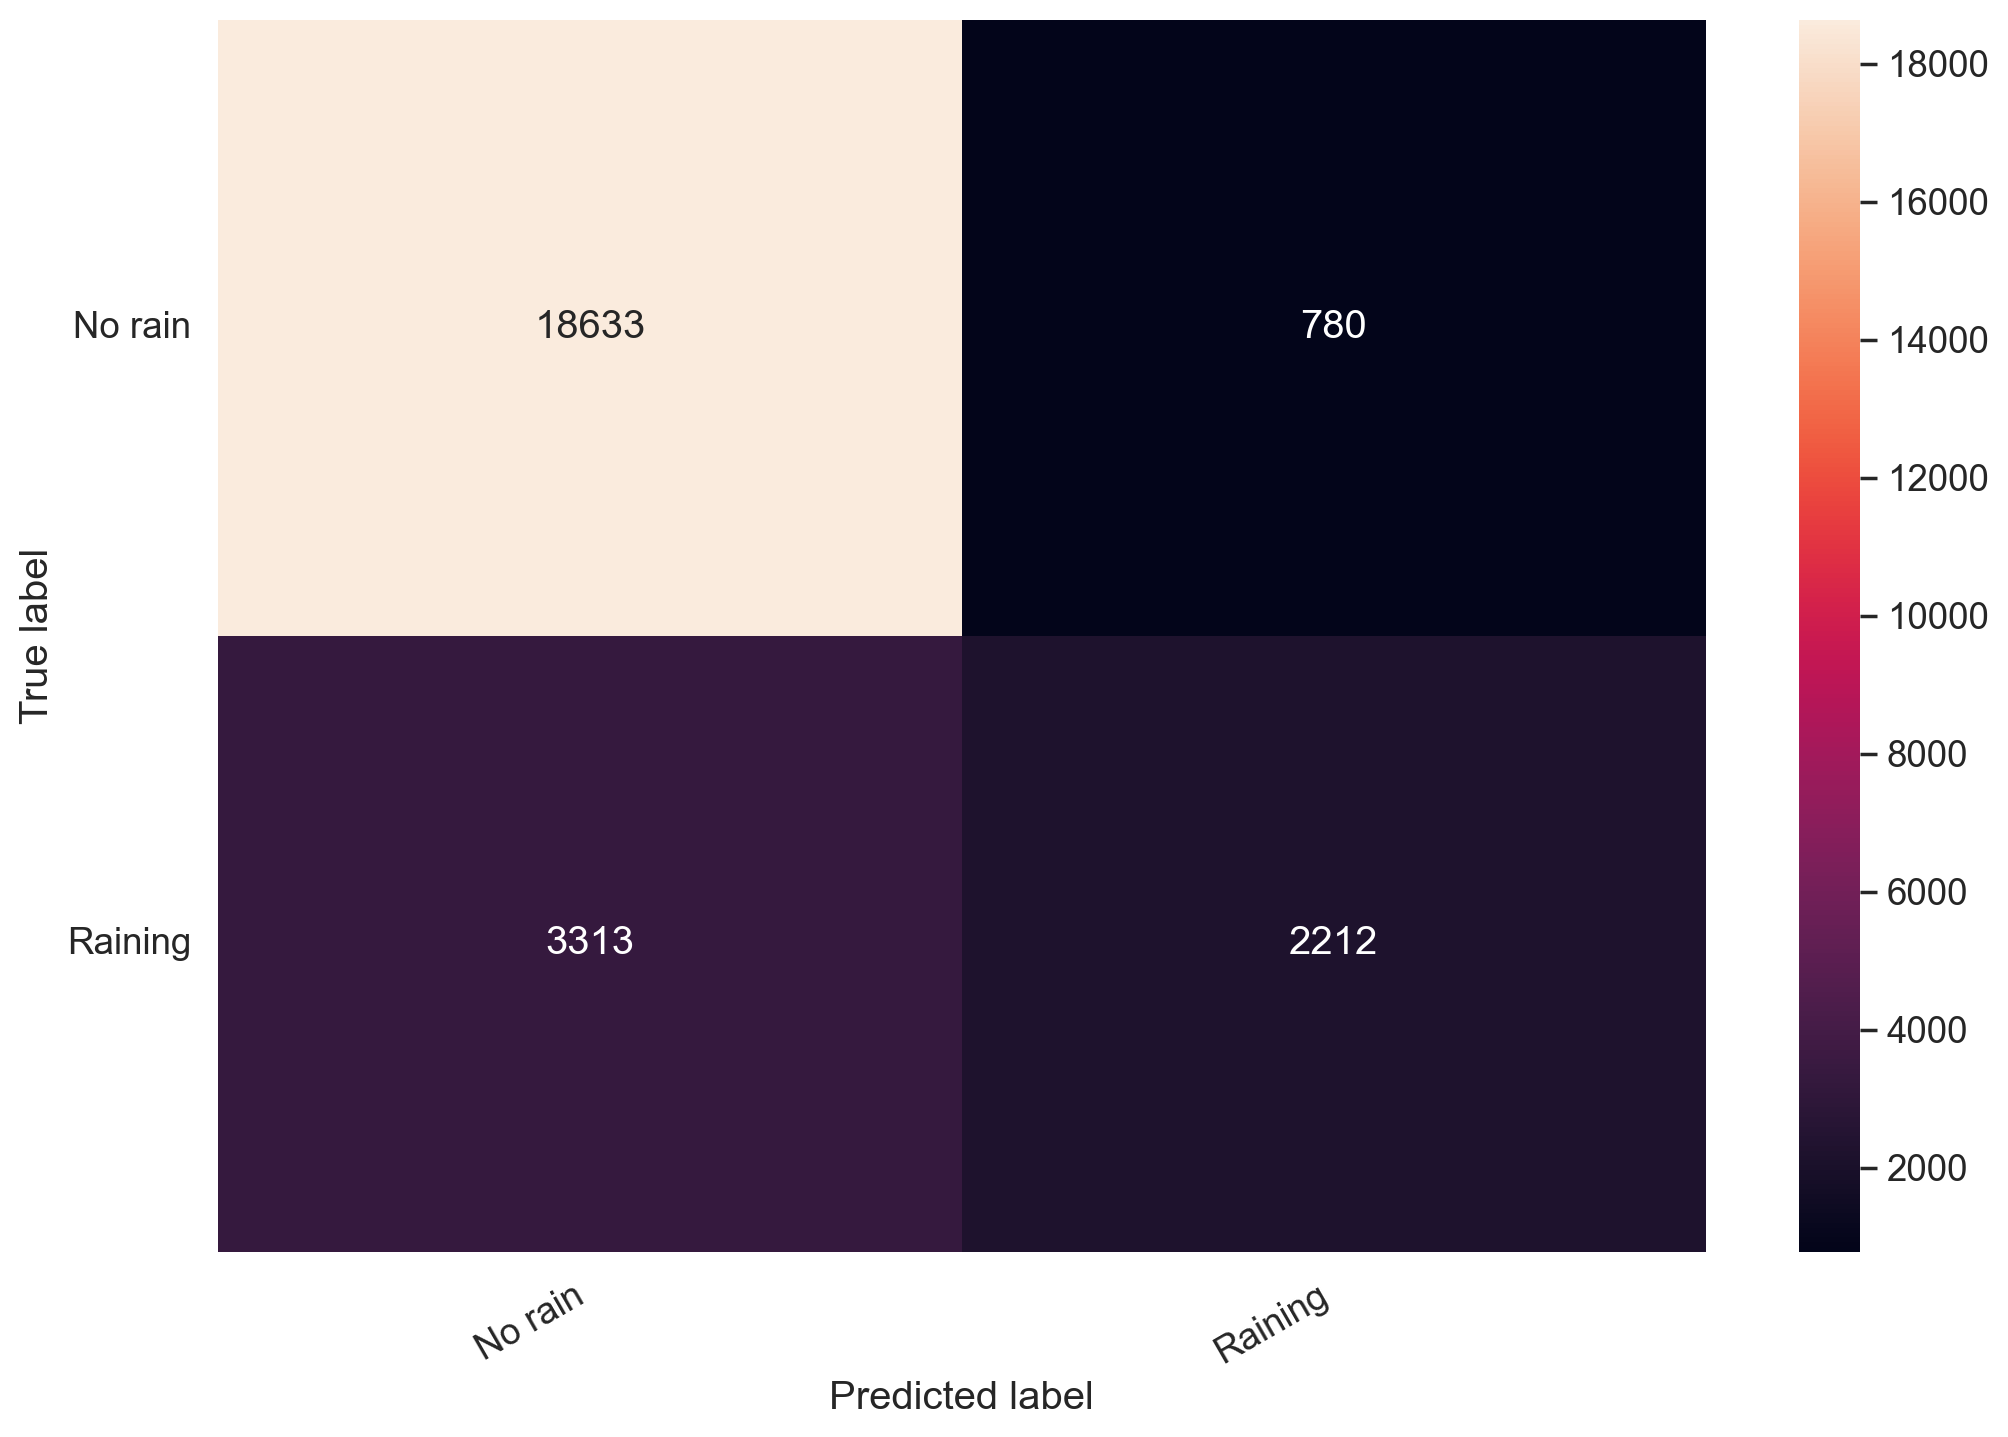

In [26]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [28]:
# Обучение и оценка модели с различными learning rates
def train_and_evaluate(learning_rate):
    net = Net(4)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []

    for epoch in range(2000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())
        
        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses

Training with learning rate: 0.0001
Training with learning rate: 0.001
Training with learning rate: 0.01
Training with learning rate: 0.1
Optimal learning rate: 0.0001


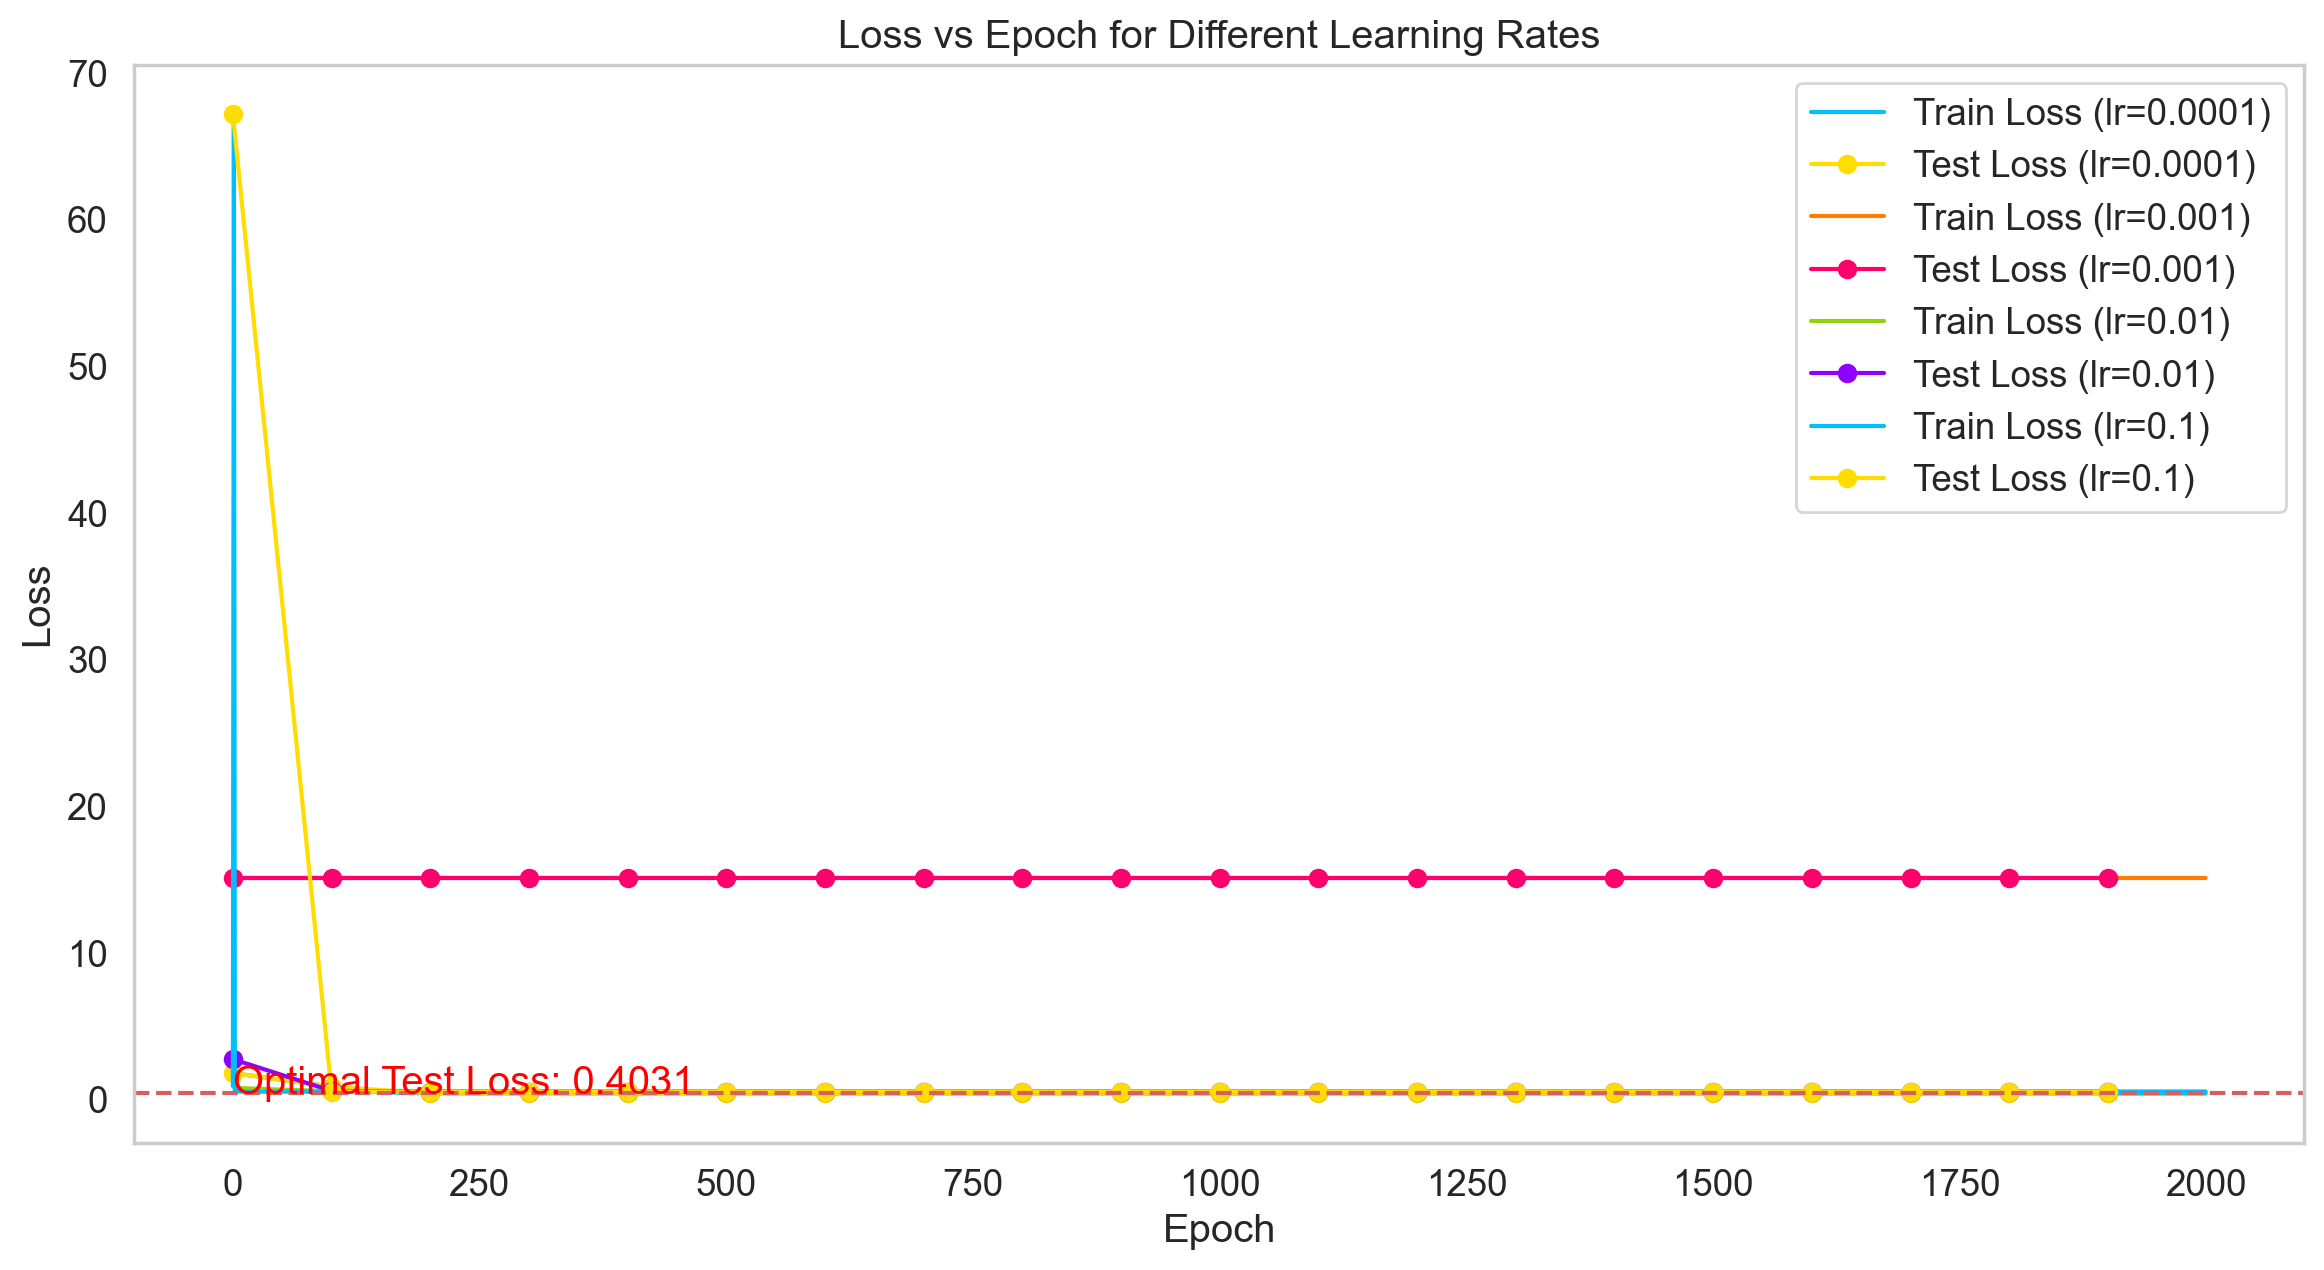

In [31]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
train_loss_dict = {}
test_loss_dict = {}
test_loss_summary = {} 

for lr in learning_rates:
    print(f'Training with learning rate: {lr}')
    train_losses, test_losses = train_and_evaluate(lr)
    train_loss_dict[lr] = train_losses
    test_loss_dict[lr] = test_losses
    test_loss_summary[lr] = test_losses[-1]

optimal_lr = min(test_loss_summary, key=test_loss_summary.get)
print(f'Optimal learning rate: {optimal_lr}')

plt.figure(figsize=(14, 7))

for lr in learning_rates:
    plt.plot(train_loss_dict[lr], label=f'Train Loss (lr={lr})')
    plt.plot(range(0, 2000, 100), test_loss_dict[lr], label=f'Test Loss (lr={lr})', marker='o')

plt.title('Loss vs Epoch for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.axhline(y=test_loss_summary[optimal_lr], color='r', linestyle='--', label='Optimal Test Loss')
plt.text(0, test_loss_summary[optimal_lr] + 0.01, f'Optimal Test Loss: {test_loss_summary[optimal_lr]:.4f}', color='red')
plt.show()

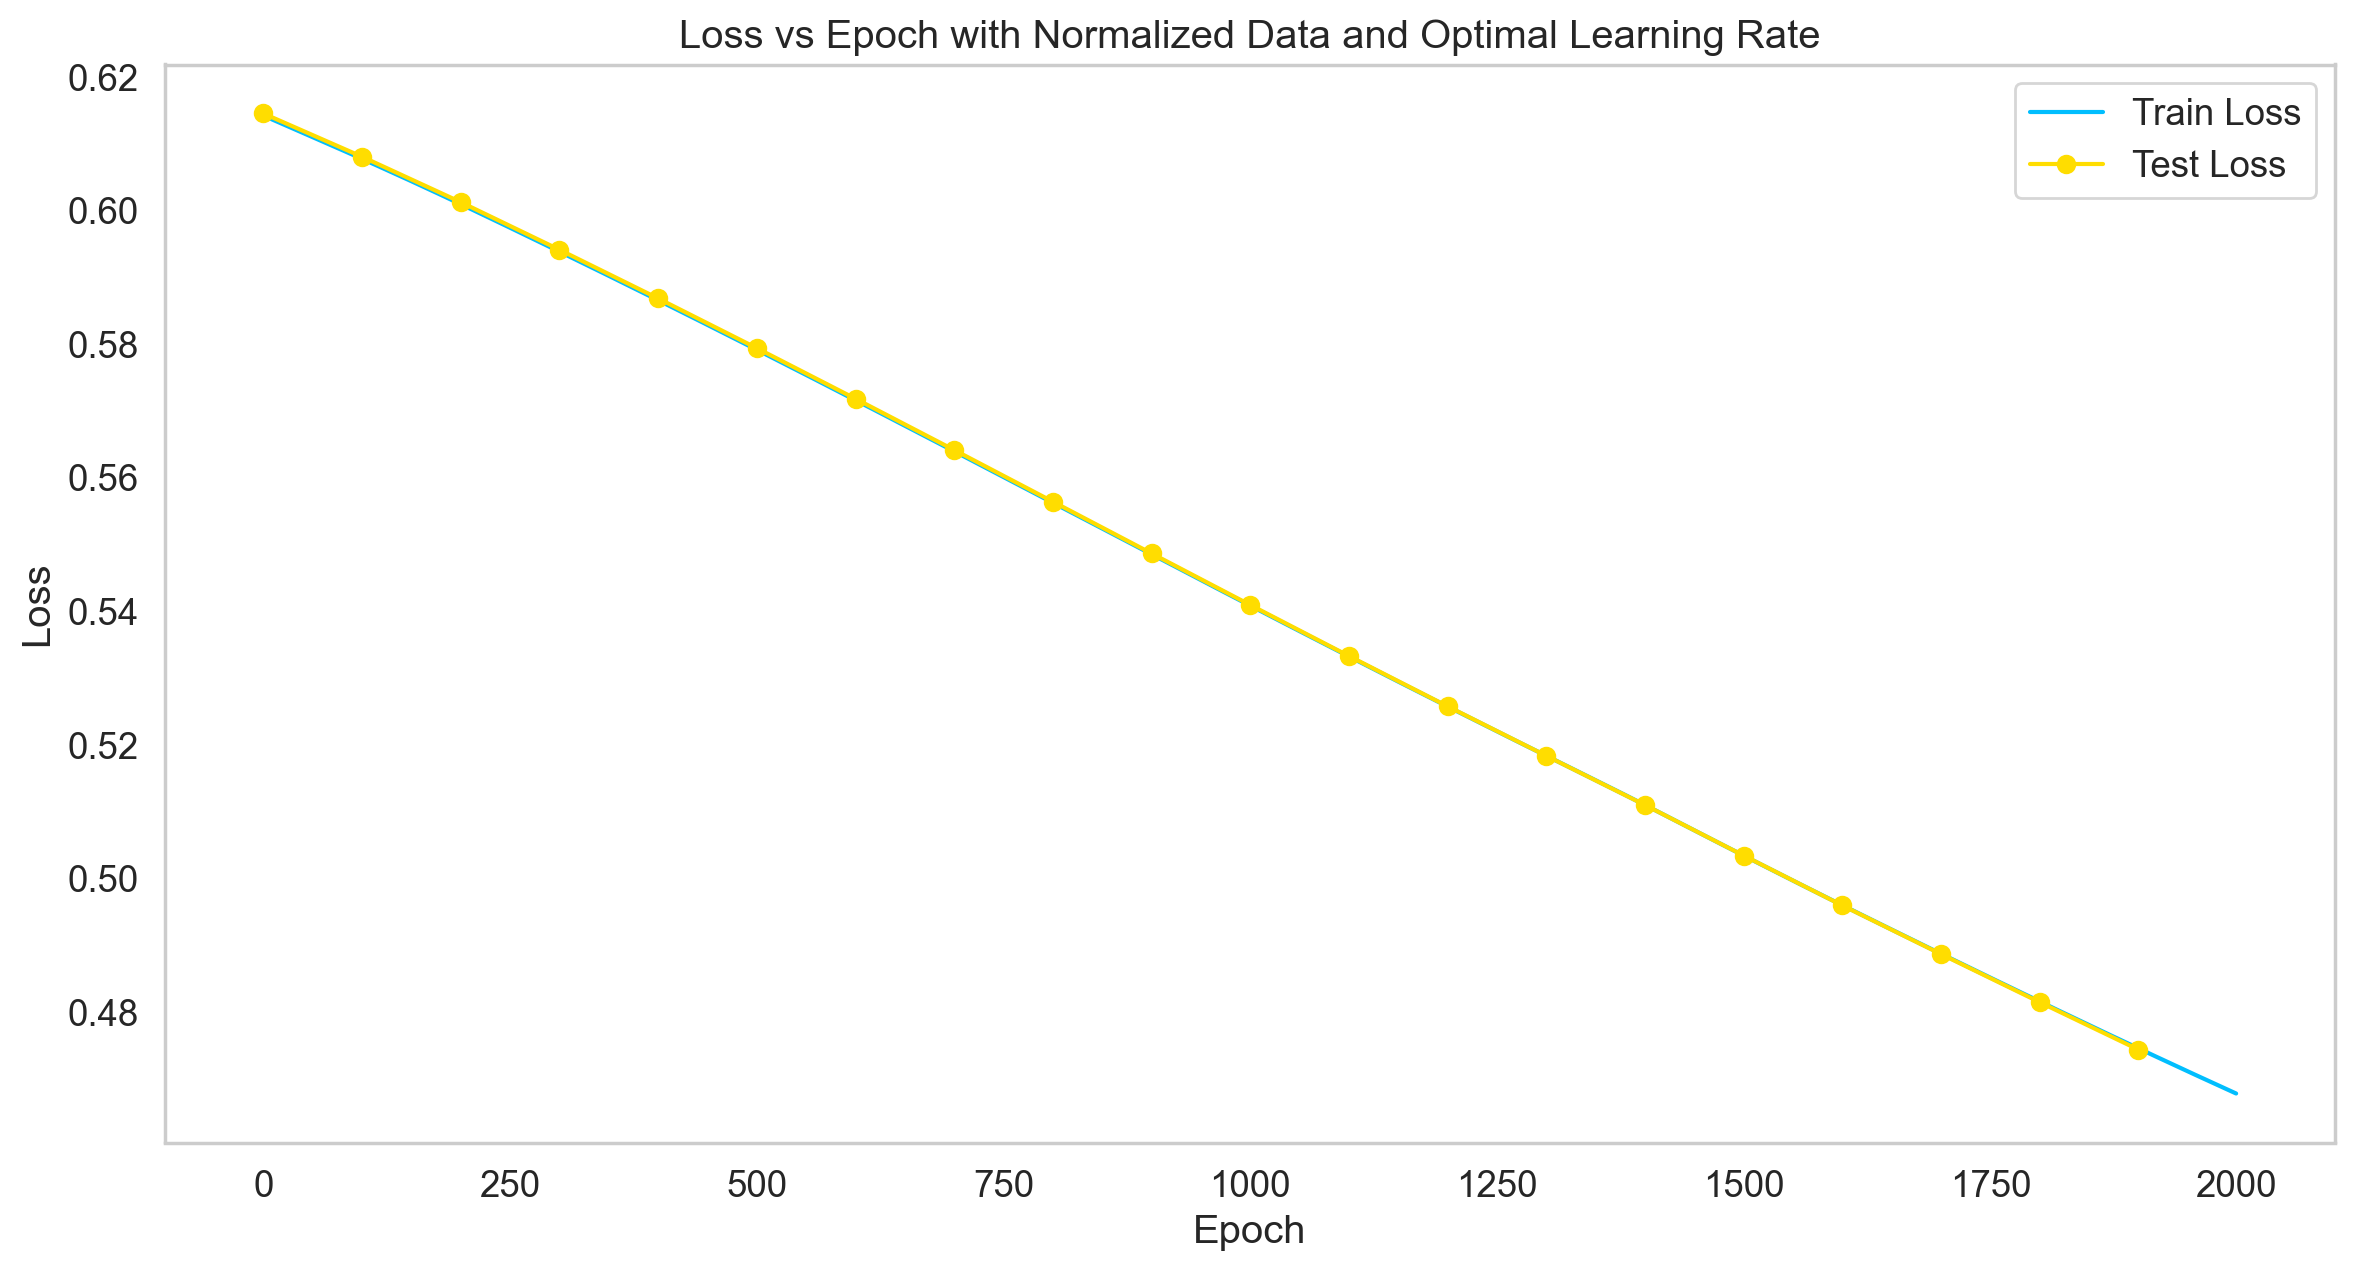

In [33]:
# 2. Примените нормализацию данных. Исследуйте скорость сходимости.
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

# Обучение с использованием нормализованных данных и оптимального learning rate
train_losses, test_losses = train_and_evaluate(optimal_lr)

plt.figure(figsize=(14, 7))
plt.plot(train_losses, label='Train Loss')
plt.plot(range(0, 2000, 100), test_losses, label='Test Loss', marker='o')

plt.title('Loss vs Epoch with Normalized Data and Optimal Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [34]:
# 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления
# скрытого слоя, Удаления/добавления нейронов в каждом слое.

class CustomNet(nn.Module):
    def __init__(self, input_size, hidden_layers):
        super(CustomNet, self).__init__()
        self.layers = nn.Sequential()
        last_size = input_size
        
        for i, layer_size in enumerate(hidden_layers):
            self.layers.add_module(f'fc{i+1}', nn.Linear(last_size, layer_size))
            self.layers.add_module(f'activation{i+1}', nn.ReLU())
            last_size = layer_size
        
        self.layers.add_module('output', nn.Linear(last_size, 1))
    
    def forward(self, x):
        return torch.sigmoid(self.layers(x))

In [ ]:
# Функция для обучения и оценки модели
def train_and_evaluate(hidden_layers, learning_rate=optimal_lr):
    net = CustomNet(4, hidden_layers)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(2000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss.item())

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses

Training with configuration: [10]
Training with configuration: [20]
Training with configuration: [10, 10]
Training with configuration: [20, 20]
Training with configuration: [30, 10]
Training with configuration: [10, 40]


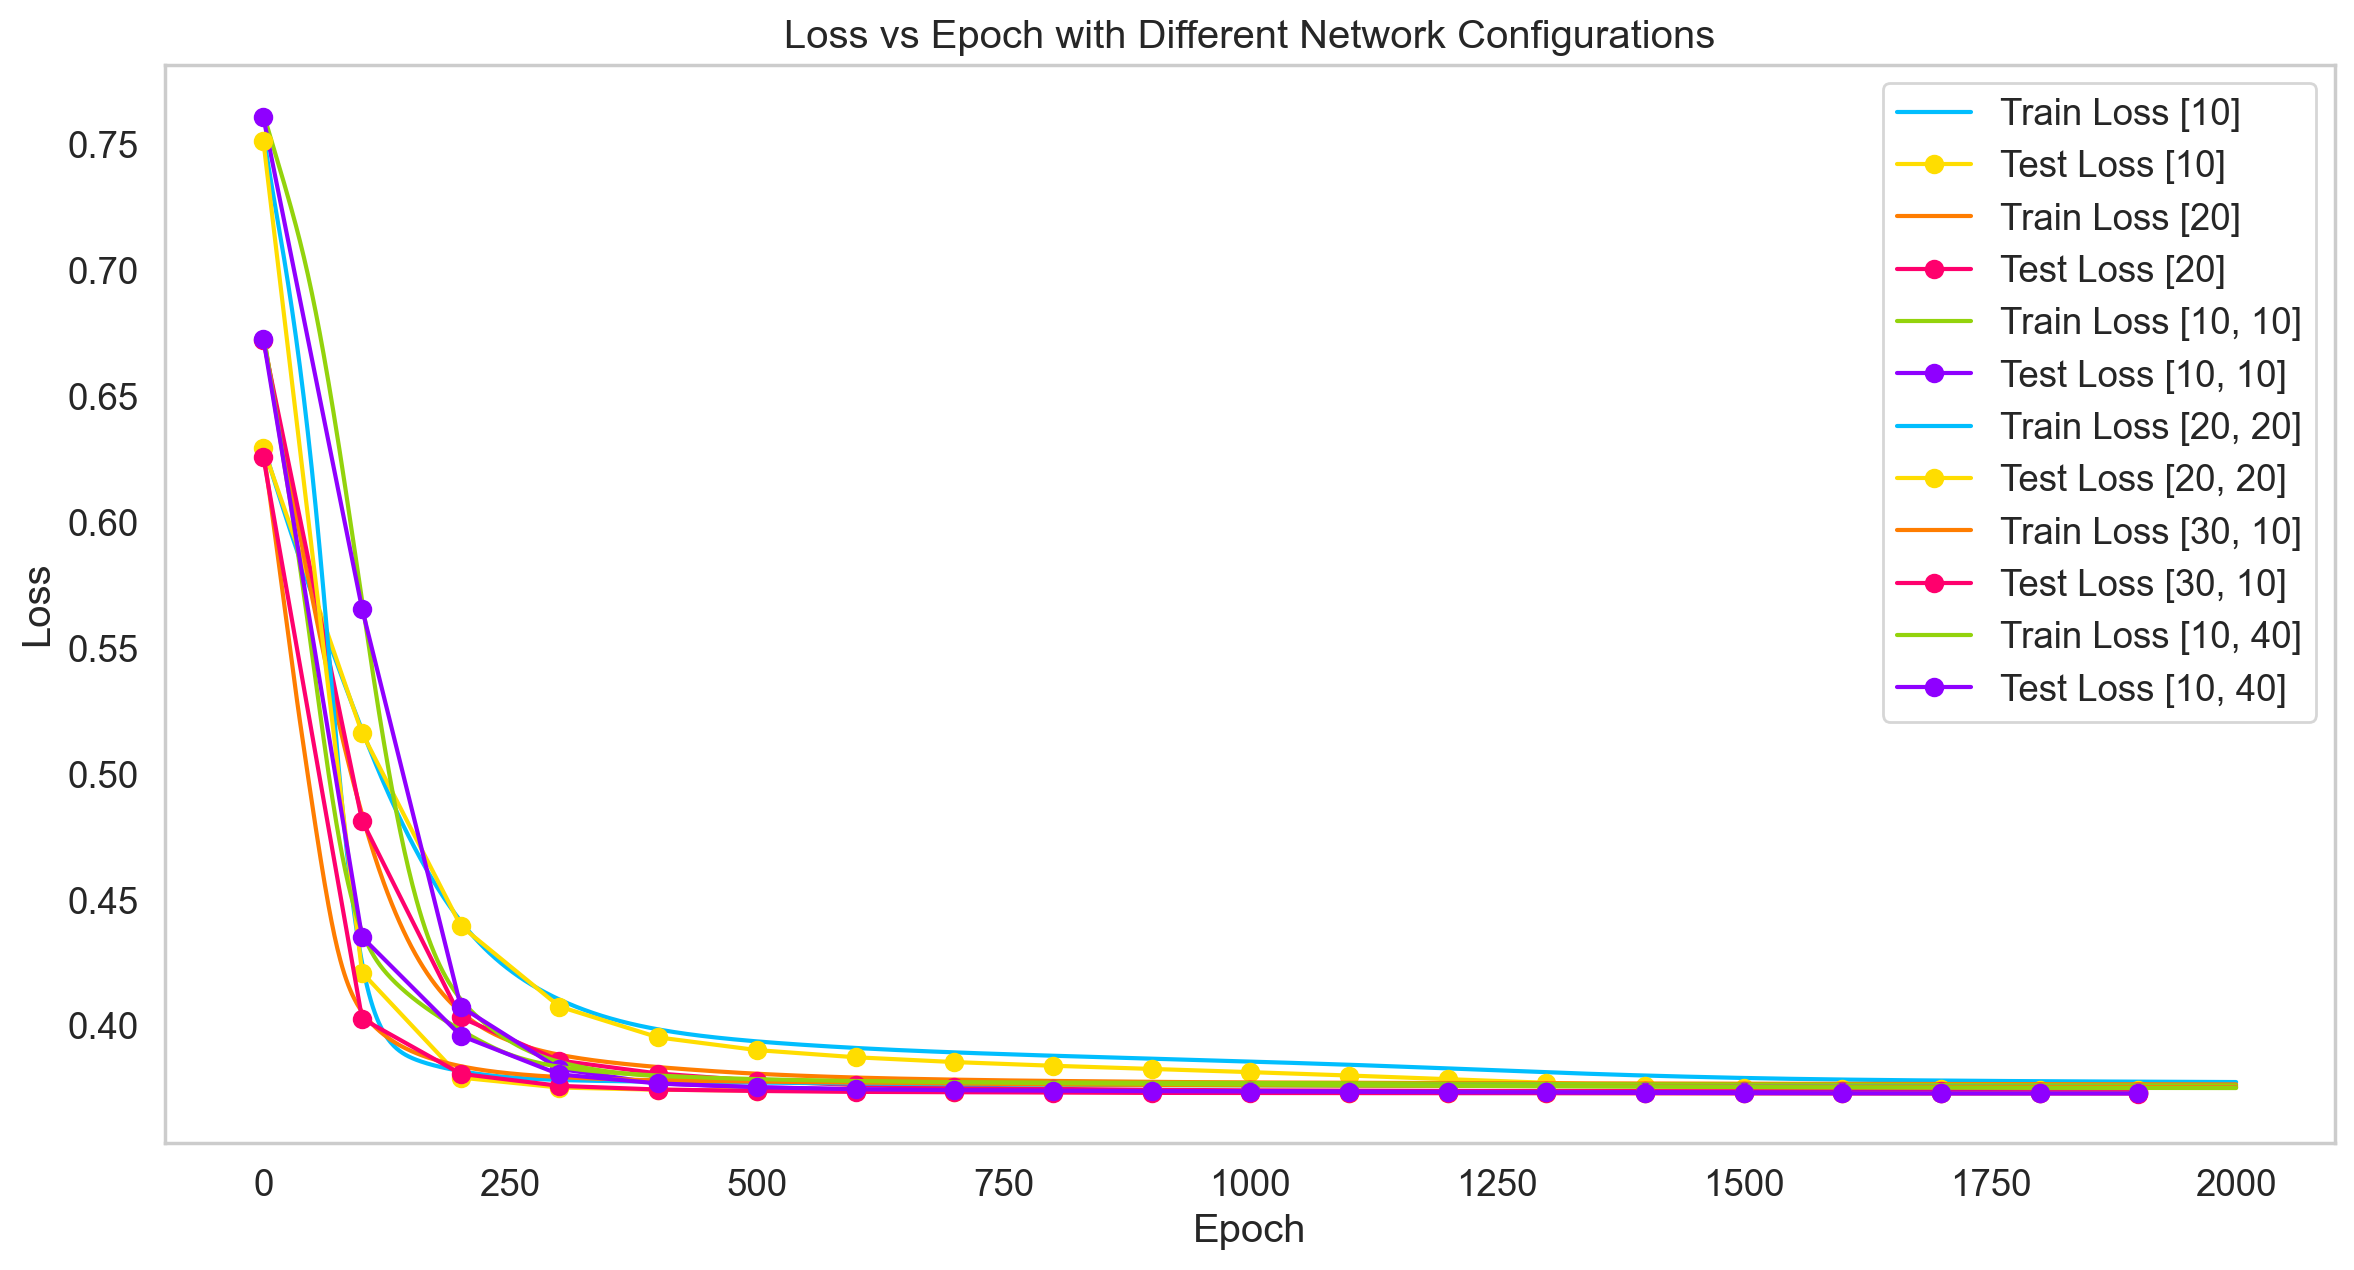

  Configuration  Final Test Loss
0          [10]         0.374353
1          [20]         0.373797
2      [10, 10]         0.373296
3      [20, 20]         0.373256
4      [30, 10]         0.373045
5      [10, 40]         0.373087


In [36]:
configurations = [
    [10],               # Один скрытый слой с 10 нейронами
    [20],               # Один скрытый слой с 20 нейронами
    [10, 10],           # Два скрытых слоя с 10 нейронами
    [20, 20],           # Два скрытых слоя с 20 нейронами
    [30, 10],           # Один скрытый слой с 30 нейронами и один с 10
    [10, 40]            # Один скрытый слой с 10 нейронами и один с 40
]
results = {}

for config in configurations:
    print(f'Training with configuration: {config}')
    train_losses, test_losses = train_and_evaluate(config)
    results[str(config)] = {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'final_test_loss': test_losses[-1] if test_losses else None
    }

plt.figure(figsize=(14, 7))

for config, data in results.items():
    plt.plot(data['train_loss'], label=f'Train Loss {config}')
    plt.plot(range(0, 2000, 100), data['test_loss'], label=f'Test Loss {config}', marker='o')

plt.title('Loss vs Epoch with Different Network Configurations')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

results_df = pd.DataFrame({
    'Configuration': [k for k in results.keys()],
    'Final Test Loss': [v['final_test_loss'] for v in results.values()]
})
print(results_df)

In [42]:
# 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

class CustomNet(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(CustomNet, self).__init__()
        self.layers = nn.Sequential()
        last_size = input_size
        
        for i, layer_size in enumerate(hidden_layers):
            self.layers.add_module(f'fc{i+1}', nn.Linear(last_size, layer_size))
            self.layers.add_module(f'activation{i+1}', activation_fn)
            last_size = layer_size
        
        self.layers.add_module('output', nn.Linear(last_size, 1))
    
    def forward(self, x):
        return torch.sigmoid(self.layers(x))

In [43]:
# Функция для обучения и оценки модели
def train_and_evaluate(hidden_layers, activation_fn, learning_rate=optimal_lr):
    net = CustomNet(4, hidden_layers, activation_fn)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(2000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss.item())

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses

Training with activation: ReLU
Training with activation: Sigmoid
Training with activation: Tanh
Training with activation: LeakyReLU
Training with activation: ELU


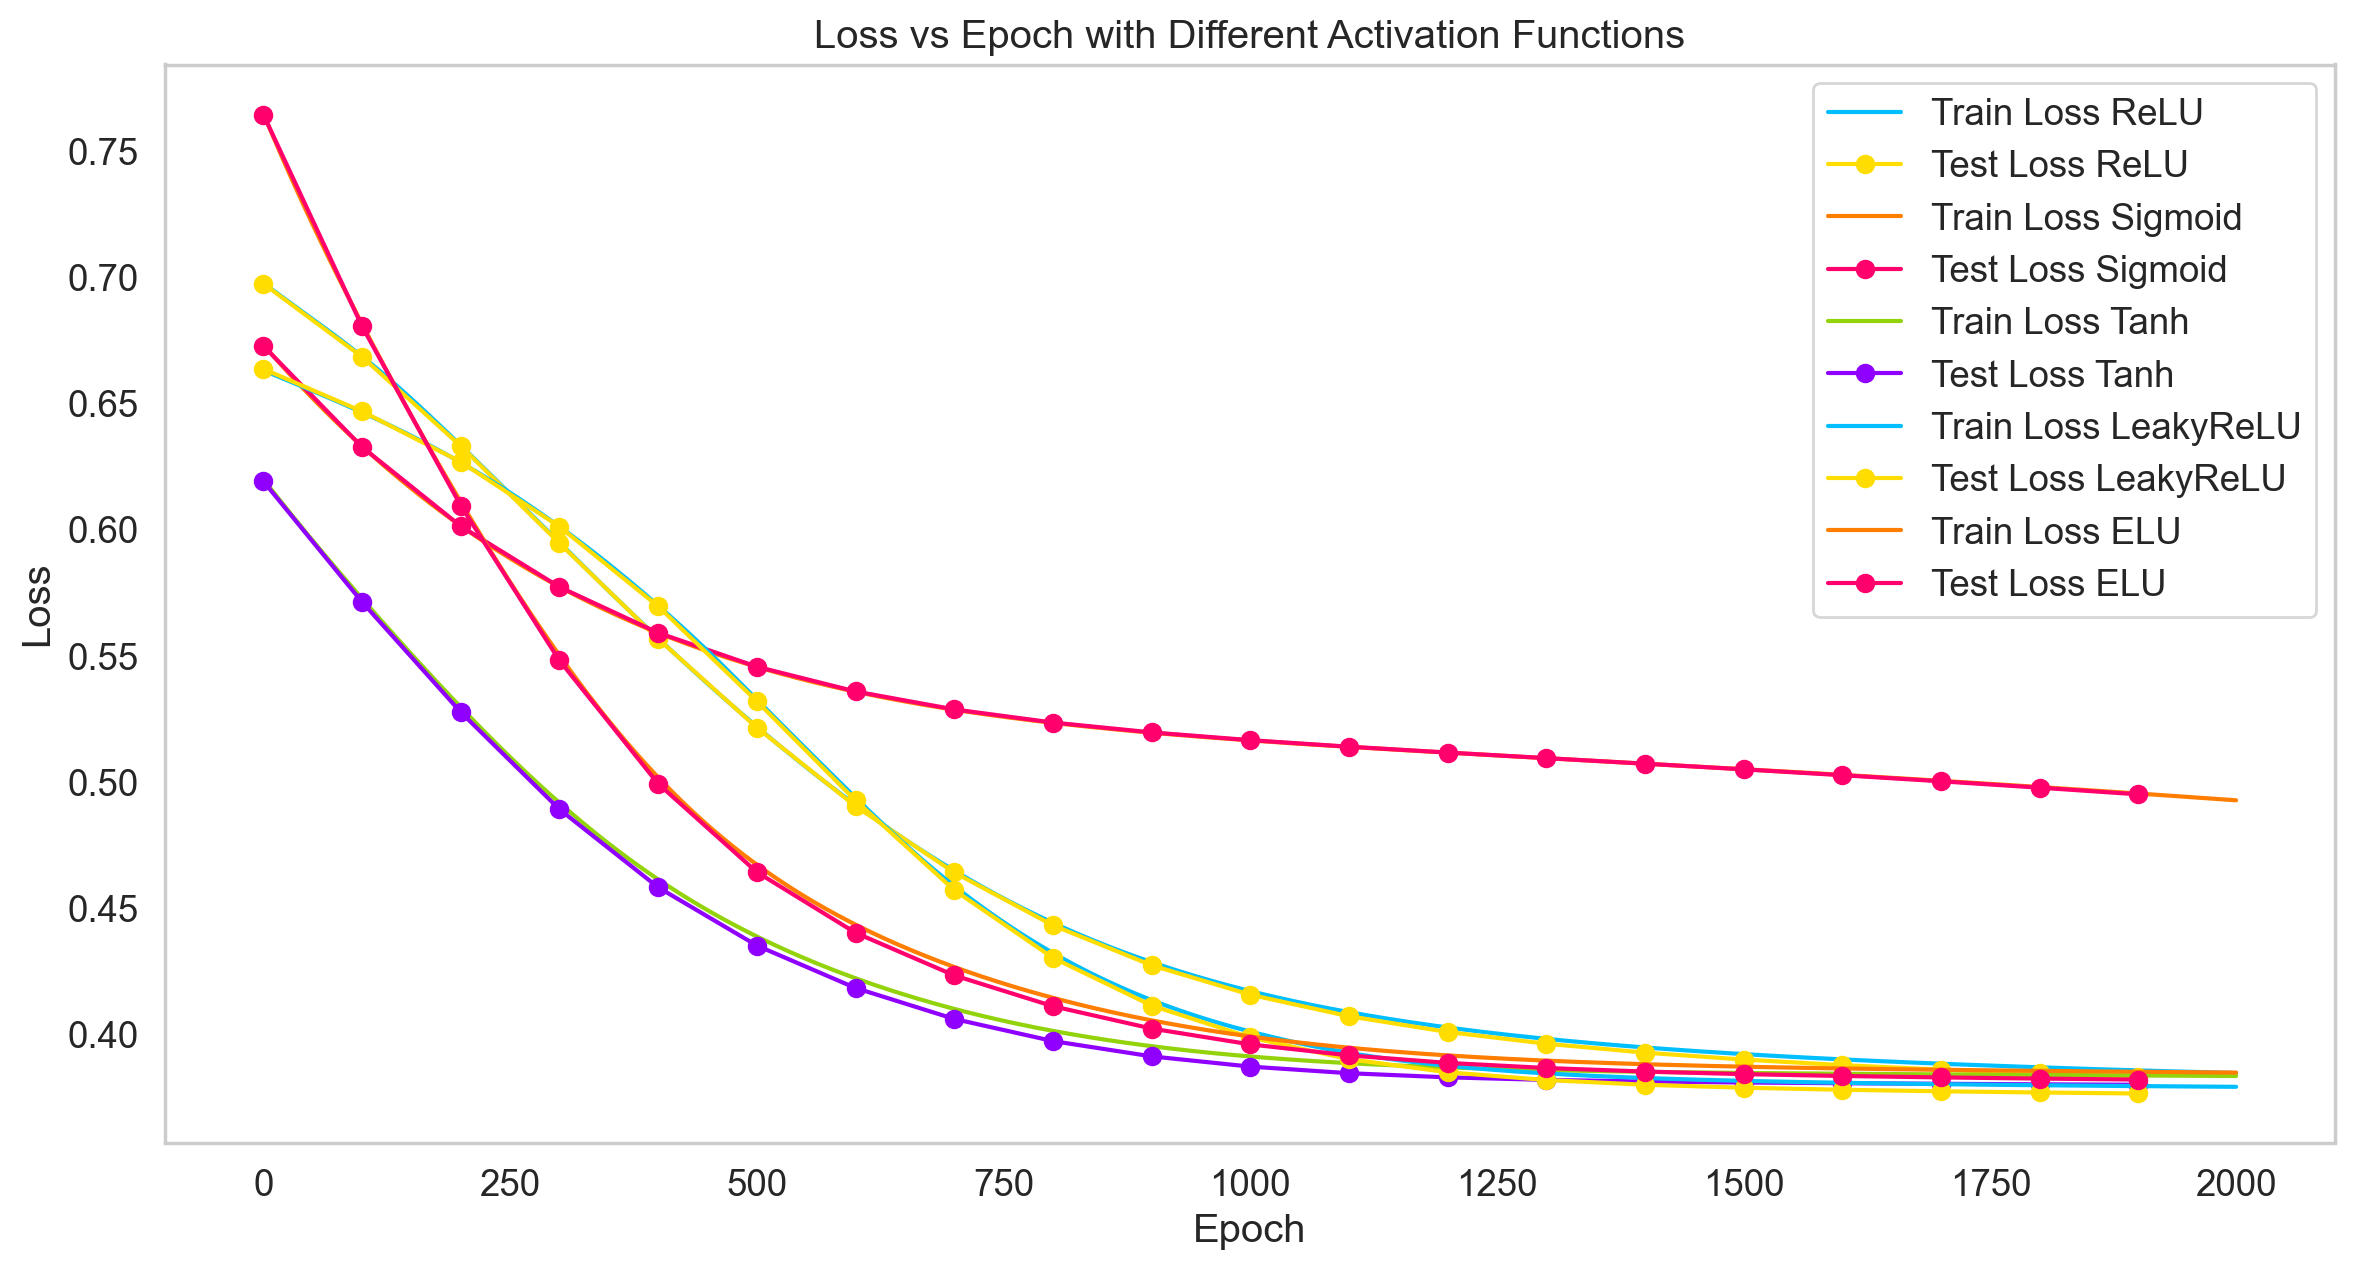

  Activation Function  Final Test Loss
0                ReLU         0.383244
1             Sigmoid         0.495110
2                Tanh         0.380028
3           LeakyReLU         0.376582
4                 ELU         0.382098


In [44]:
activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LeakyReLU': nn.LeakyReLU(),
    'ELU': nn.ELU(),
}

results = {}

for name, activation_fn in activation_functions.items():
    print(f'Training with activation: {name}')
    hidden_layers = [20, 20] 
    train_losses, test_losses = train_and_evaluate(hidden_layers, activation_fn)
    results[name] = {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'final_test_loss': test_losses[-1] if test_losses else None
    }

plt.figure(figsize=(14, 7))

for name, data in results.items():
    plt.plot(data['train_loss'], label=f'Train Loss {name}')
    plt.plot(range(0, 2000, 100), data['test_loss'], label=f'Test Loss {name}', marker='o')

plt.title('Loss vs Epoch with Different Activation Functions')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

results_df = pd.DataFrame({
    'Activation Function': [k for k in results.keys()],
    'Final Test Loss': [v['final_test_loss'] for v in results.values()]
})
print(results_df)

In [46]:
# 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
# https://pytorch.org/docs/stable/optim.html

class CustomNet(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(CustomNet, self).__init__()
        self.layers = nn.Sequential()
        last_size = input_size
        
        for i, layer_size in enumerate(hidden_layers):
            self.layers.add_module(f'fc{i+1}', nn.Linear(last_size, layer_size))
            self.layers.add_module(f'activation{i+1}', activation_fn)
            last_size = layer_size
        
        self.layers.add_module('output', nn.Linear(last_size, 1))
    
    def forward(self, x):
        return torch.sigmoid(self.layers(x))

In [45]:
def train_and_evaluate(hidden_layers, activation_fn, optimizer_class, learning_rate=optimal_lr):
    net = CustomNet(4, hidden_layers, activation_fn)
    criterion = nn.BCELoss()
    optimizer = optimizer_class(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(2000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses

Training with optimizer: SGD
Training with optimizer: Adam
Training with optimizer: AdamW
Training with optimizer: RMSprop
Training with optimizer: Adagrad


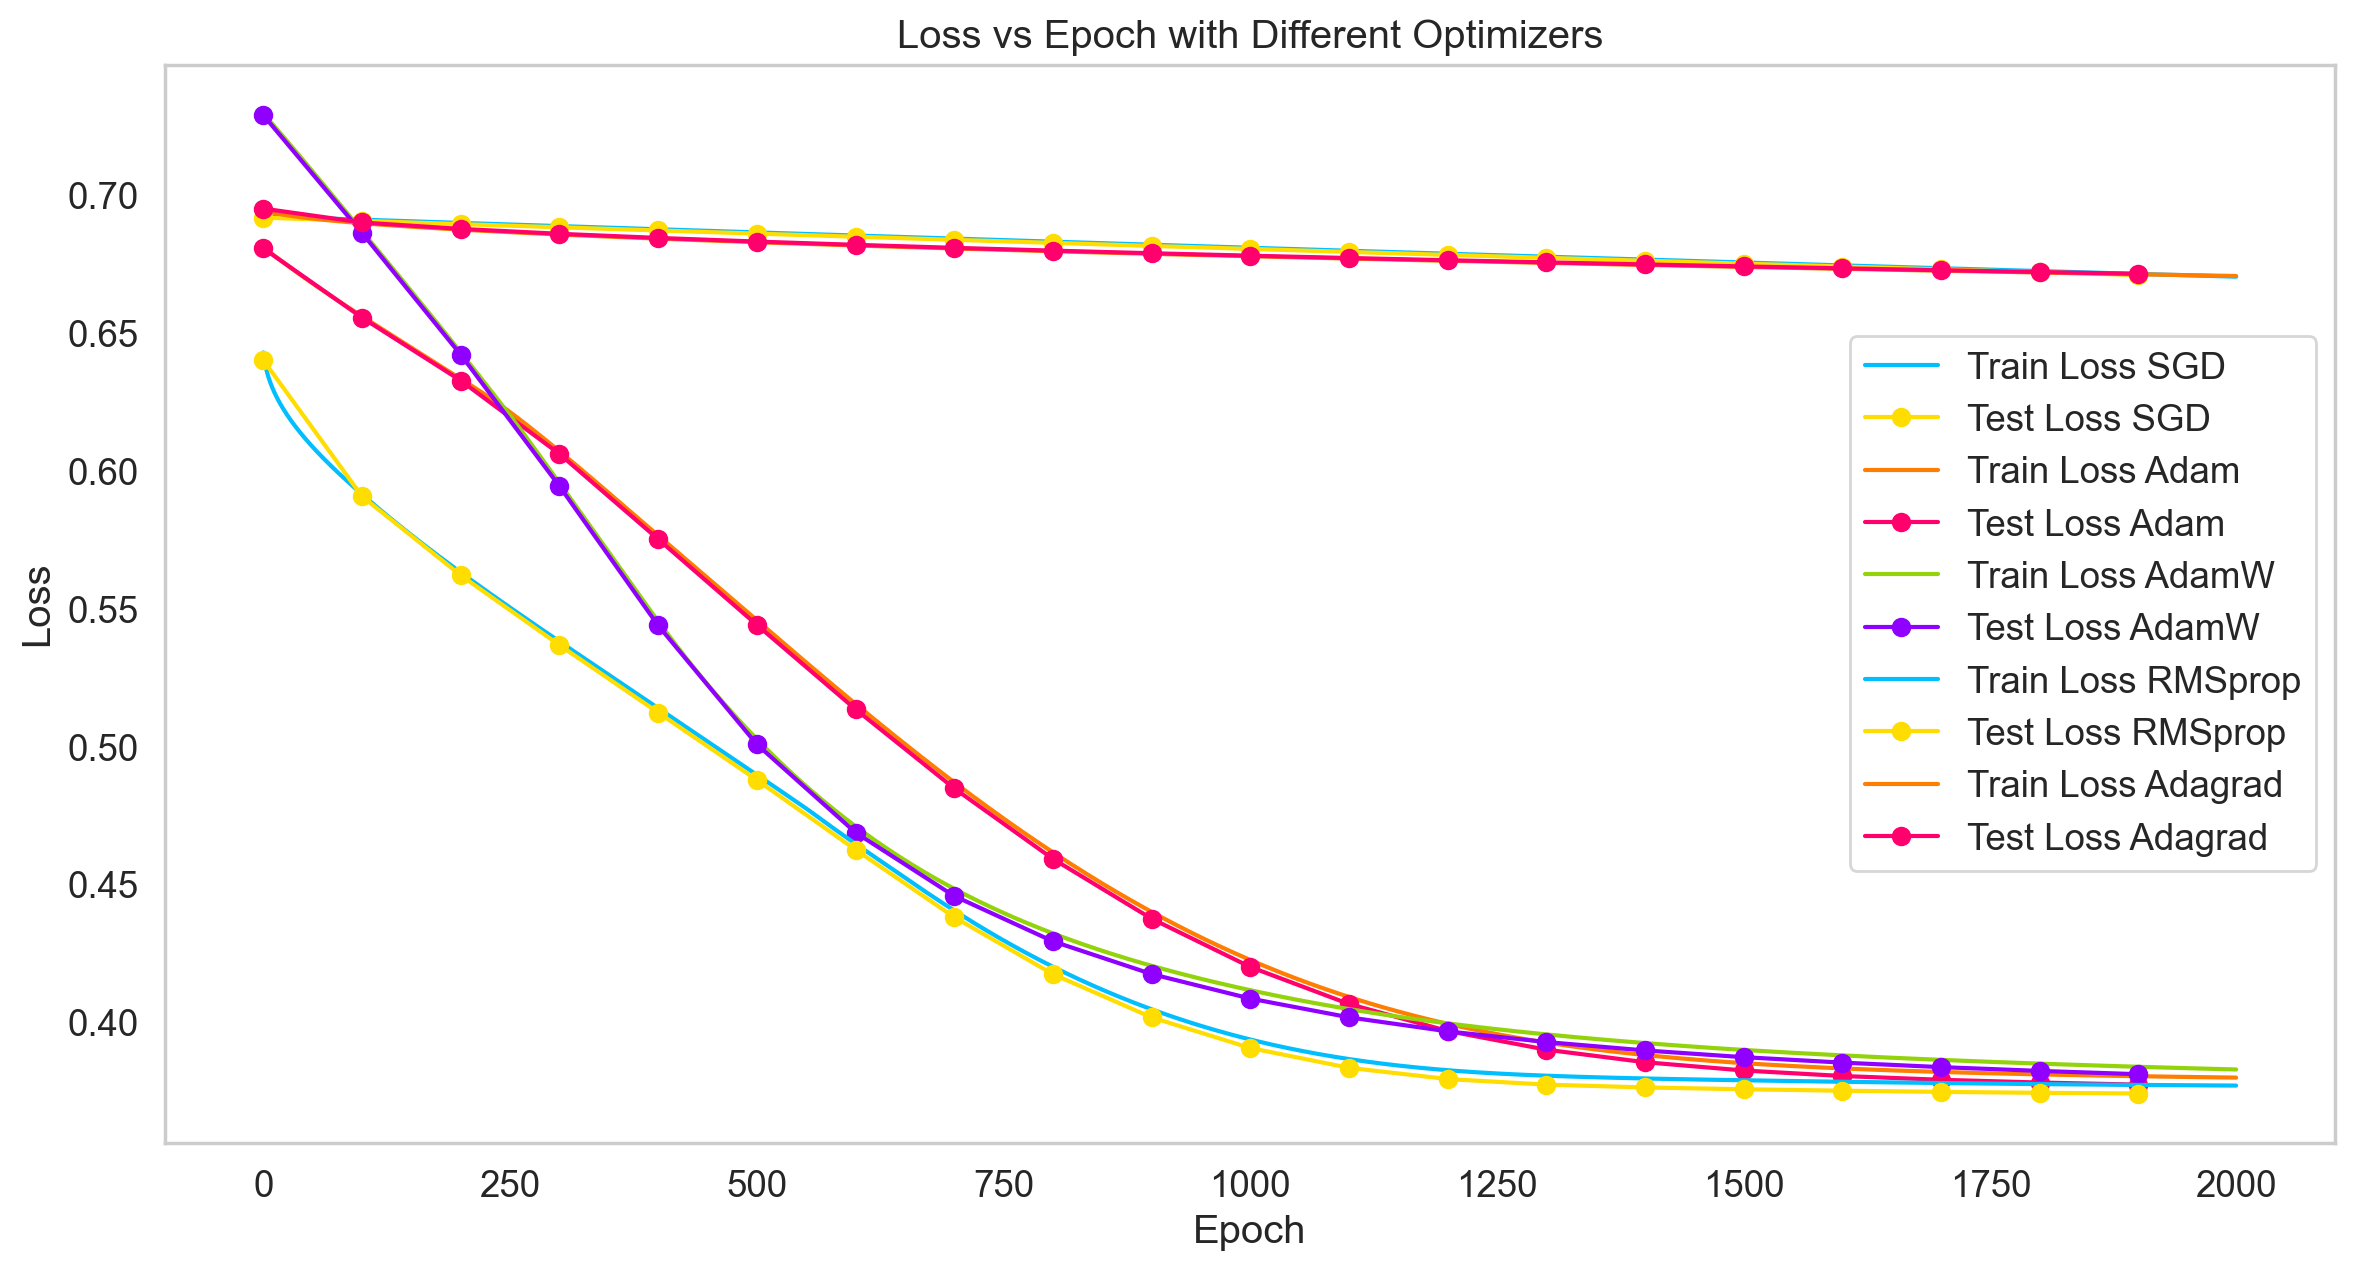

  Optimizer  Final Test Loss
0       SGD         0.670878
1      Adam         0.377383
2     AdamW         0.381162
3   RMSprop         0.374168
4   Adagrad         0.671313


In [47]:
optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
    'RMSprop': optim.RMSprop,
    'Adagrad': optim.Adagrad,
}

activation_fn = nn.LeakyReLU()
hidden_layers = [20, 20]

results = {}

for name, optimizer_class in optimizers.items():
    print(f'Training with optimizer: {name}')
    train_losses, test_losses = train_and_evaluate(hidden_layers, activation_fn, optimizer_class)
    results[name] = {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'final_test_loss': test_losses[-1] if test_losses else None
    }

plt.figure(figsize=(14, 7))

for name, data in results.items():
    plt.plot(data['train_loss'], label=f'Train Loss {name}')
    plt.plot(range(0, 2000, 100), data['test_loss'], label=f'Test Loss {name}', marker='o')

plt.title('Loss vs Epoch with Different Optimizers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

results_df = pd.DataFrame({
    'Optimizer': [k for k in results.keys()],
    'Final Test Loss': [v['final_test_loss'] for v in results.values()]
})
print(results_df)

In [49]:
# 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.
# Импорт необходимых библиотек

class CustomNet(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn, weight_init):
        super(CustomNet, self).__init__()
        self.layers = nn.Sequential()
        last_size = input_size
        
        for i, layer_size in enumerate(hidden_layers):
            self.layers.add_module(f'fc{i+1}', nn.Linear(last_size, layer_size))
            self.layers.add_module(f'activation{i+1}', activation_fn)
            last_size = layer_size
        
        self.layers.add_module('output', nn.Linear(last_size, 1))
        
        self.apply(weight_init) 

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

In [50]:
# Функция для обучения и оценки модели
def train_and_evaluate(hidden_layers, activation_fn, weight_init, learning_rate=optimal_lr):
    net = CustomNet(4, hidden_layers, activation_fn, weight_init)
    criterion = nn.BCELoss()
    optimizer = optim.RMSprop(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(2000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses

In [52]:
def init_weights_zero(m):
    if isinstance(m, nn.Linear):
        nn.init.zeros_(m.weight)

def init_weights_random(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.01)

def init_weights_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

def init_weights_Kaiming(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu') 

Training with weight initialization: Zero
Training with weight initialization: Random
Training with weight initialization: Xavier
Training with weight initialization: Kaiming


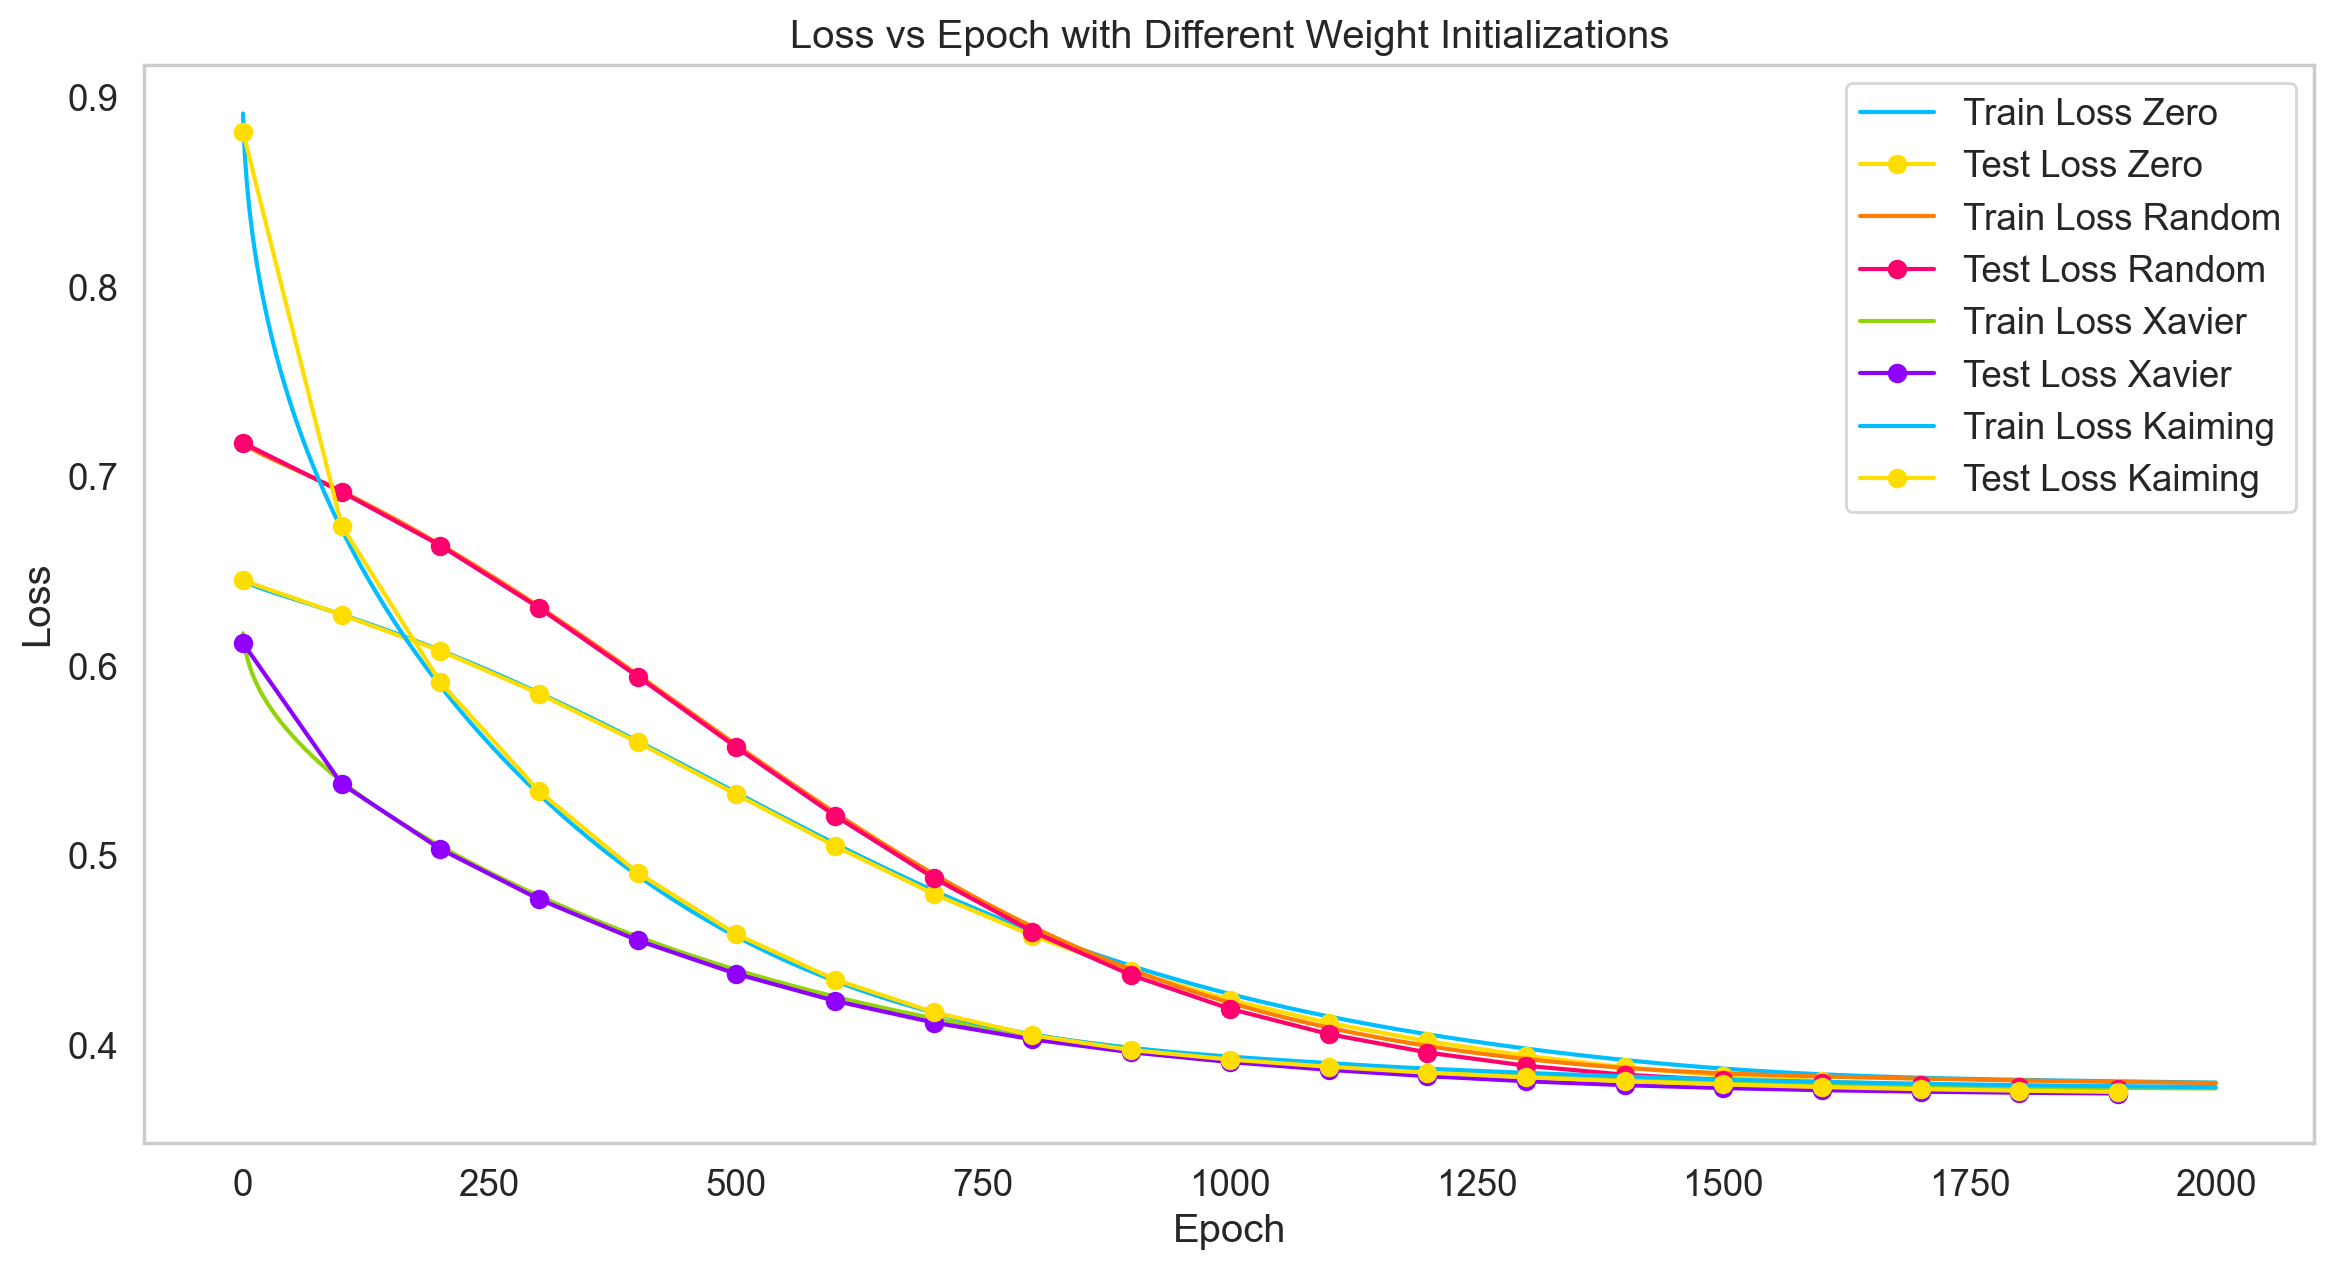

  Weight Initialization  Final Test Loss
0                  Zero         0.377294
1                Random         0.376954
2                Xavier         0.374359
3               Kaiming         0.375188


In [54]:
weight_initializers = {
    'Zero': init_weights_zero,
    'Random': init_weights_random,
    'Xavier': init_weights_xavier,
    'Kaiming': init_weights_Kaiming,
}

activation_fn = nn.LeakyReLU()
hidden_layers = [20, 20]

results = {}

for name, weight_init in weight_initializers.items():
    print(f'Training with weight initialization: {name}')
    train_losses, test_losses = train_and_evaluate(hidden_layers, activation_fn, weight_init)
    results[name] = {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'final_test_loss': test_losses[-1] if test_losses else None
    }

plt.figure(figsize=(14, 7))

for name, data in results.items():
    plt.plot(data['train_loss'], label=f'Train Loss {name}')
    plt.plot(range(0, 2000, 100), data['test_loss'], label=f'Test Loss {name}', marker='o')

plt.title('Loss vs Epoch with Different Weight Initializations')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

results_df = pd.DataFrame({
    'Weight Initialization': [k for k in results.keys()],
    'Final Test Loss': [v['final_test_loss'] for v in results.values()]
})
print(results_df)